# Modeling Career Choice


<a id='index-0'></a>

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit, prange
from quantecon.distributions import BetaBinomial
from scipy.special import binom, beta
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


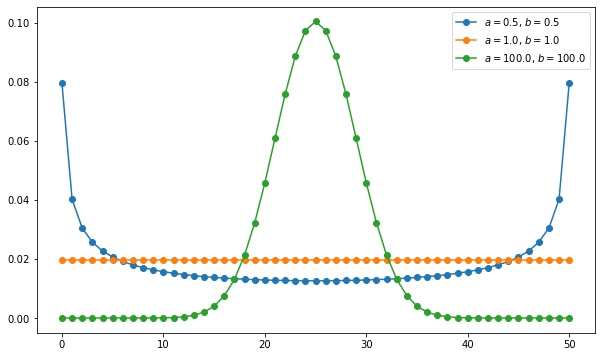

In [2]:
def gen_probs(n, a, b):
    probs = np.zeros(n+1)
    for k in range(n+1):
        probs[k] = binom(n, k) * beta(k + a, n - k + b) / beta(a, b)
    return probs

n = 50
a_vals = [0.5, 1, 100]
b_vals = [0.5, 1, 100]
fig, ax = plt.subplots(figsize=(10, 6))
for a, b in zip(a_vals, b_vals):
    ab_label = f'$a = {a:.1f}$, $b = {b:.1f}$'
    ax.plot(list(range(0, n+1)), gen_probs(n, a, b), '-o', label=ab_label)
ax.legend()
plt.show()

In [3]:
class CareerWorkerProblem:

    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=1,
                 F_b=1,
                 G_a=1,
                 G_b=1):

        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # Set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # Set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

In [4]:
def operator_factory(cw, parallel_flag=True):

    """
    Returns jitted versions of the Bellman operator and the
    greedy policy function

    cw is an instance of ``CareerWorkerProblem``
    """

    θ, ϵ, β = cw.θ, cw.ϵ, cw.β
    F_probs, G_probs = cw.F_probs, cw.G_probs
    F_mean, G_mean = cw.F_mean, cw.G_mean

    @njit(parallel=parallel_flag)
    def T(v):
        "The Bellman operator"

        v_new = np.empty_like(v)

        for i in prange(len(v)):
            for j in prange(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]                    # Stay put
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs        # New job
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs  # New life
                v_new[i, j] = max(v1, v2, v3)

        return v_new

    @njit
    def get_greedy(v):
        "Computes the v-greedy policy"

        σ = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs
                if v1 > max(v2, v3):
                    action = 1
                elif v2 > max(v1, v3):
                    action = 2
                else:
                    action = 3
                σ[i, j] = action

        return σ

    return T, get_greedy

In [5]:
def solve_model(cw,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(cw, parallel_flag=use_parallel)

    # Set up loop
    v = np.ones((cw.grid_size, cw.grid_size)) * 100  # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

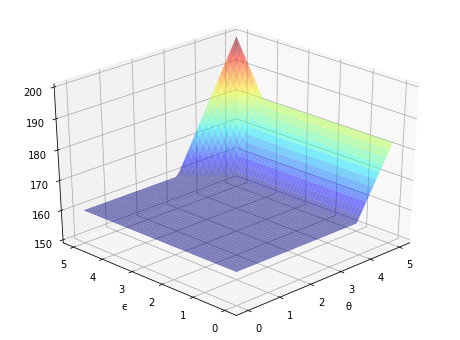

In [6]:
cw = CareerWorkerProblem()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
ax.plot_surface(tg,
                eg,
                v_star.T,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set(xlabel='θ', ylabel='ϵ', zlim=(150, 200))
ax.view_init(ax.elev, 225)
plt.show()

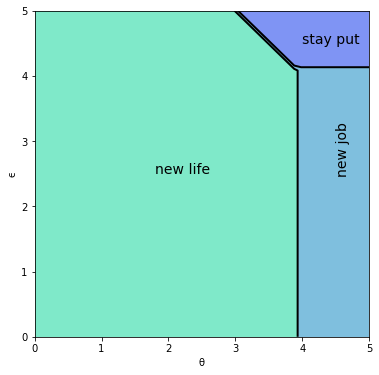

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()

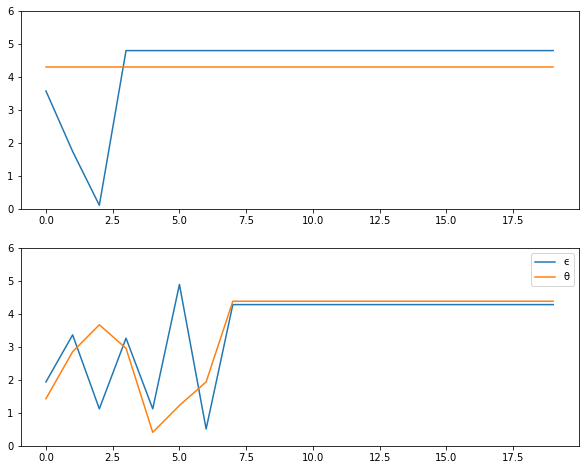

In [8]:
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
v_star = solve_model(cw, verbose=False)
T, get_greedy = operator_factory(cw)
greedy_star = get_greedy(v_star)

def gen_path(optimal_policy, F, G, t=20):
    i = j = 0
    θ_index = []
    ϵ_index = []
    for t in range(t):
        if greedy_star[i, j] == 1:       # Stay put
            pass
        elif greedy_star[i, j] == 2:     # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j = int(qe.random.draw(F)), int(qe.random.draw(G))
        θ_index.append(i)
        ϵ_index.append(j)
    return cw.θ[θ_index], cw.ϵ[ϵ_index]


fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax in axes:
    θ_path, ϵ_path = gen_path(greedy_star, F, G)
    ax.plot(ϵ_path, label='ϵ')
    ax.plot(θ_path, label='θ')
    ax.set_ylim(0, 6)

plt.legend()
plt.show()

In [9]:
cw = CareerWorkerProblem()
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

@njit
def passage_time(optimal_policy, F, G):
    t = 0
    i = j = 0
    while True:
        if optimal_policy[i, j] == 1:    # Stay put
            return t
        elif optimal_policy[i, j] == 2:  # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j  = int(qe.random.draw(F)), int(qe.random.draw(G))
        t += 1

@njit(parallel=True)
def median_time(optimal_policy, F, G, M=25000):
    samples = np.empty(M)
    for i in prange(M):
        samples[i] = passage_time(optimal_policy, F, G)
    return np.median(samples)

median_time(greedy_star, F, G)

7.0

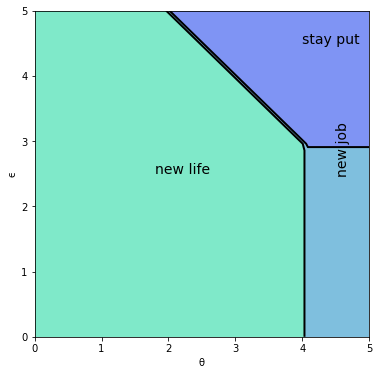

In [10]:
cw = CareerWorkerProblem(G_a=100, G_b=100)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()